In [1]:
import ee 
import geemap
import matplotlib.pyplot as plt
import numpy as np

In [222]:
# Create a map centred at (lat, lon).
Map = geemap.Map(center=[40, -100], zoom=4)

In [223]:
# Display the map.
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [224]:
#define the regions we're interested in, and also access landcover information derived from MODIS

haiti_region = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017') \
  .filter(ee.Filter.eq('country_na', 'Haiti'))

dr_region = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017') \
  .filter(ee.Filter.eq('country_na', 'Dominican Republic'))

# Load MODIS land cover categories in 2001.
landcover = ee.ImageCollection('MODIS/006/MCD12Q1') \
  .select('LC_Type1')

In [294]:
#define a colour palette to view landcover data. View all on the map above
igbpPalette =  [
    '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
    'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
    '69fff8', 'f9ffa4', '1c0dff'
]

igbpLandCoverVis = {
  'min': 1.0,
  'max': 17.0,
  'palette': igbpPalette
}
    
Map.addLayer(landcover, igbpLandCoverVis, 'landcover')
Map.addLayer(haiti_region, {'color':'red'}, 'haiti_region')
Map.addLayer(dr_region, {'color':'blue'}, 'dr_region')

In [228]:
class_images = landcover.select('LC_Type1') #select the landcover band where an integer represents the class
 #(see https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1#description)

#empty list to store data
data = {'haiti':[],
       'dr':[]}

for country in ['haiti','dr']:
    if country == 'haiti':
        region = haiti_region
    else:
        region = dr_region
        
    #go through 19 years of data
    N = 19
    for i in range(N):
        #access a particular year in the collection of images
        class_image = ee.Image(class_images.toList(class_images.size()).get(i))

        #empty array to store data
        year_data = np.zeros(18)

        #print year of image
        print(class_image.get('system:index').getInfo())

        #get area of pixels as a band, perform a reduction so we get the number of pixels for each class for the 
        #particular year
        image = ee.Image.pixelArea().addBands(class_image)
        sums = image.reduceRegion(**{
              'reducer': ee.Reducer.sum().group(**{
                'groupField': 1,
                'groupName': 'code',
              }),
              'geometry': region.geometry(),
              'scale': 500,
              'maxPixels': 1e8
            })

        #messy way of sorting the dictionary into a nicer structure
        class_year_data = sums.getInfo().get('groups')
        for class_type in class_year_data:
            year_data[class_type['code']] = class_type['sum']

        data[country].append((year_data/year_data.sum()))

2001_01_01
2002_01_01
2003_01_01
2004_01_01
2005_01_01
2006_01_01
2007_01_01
2008_01_01
2009_01_01
2010_01_01
2011_01_01
2012_01_01
2013_01_01
2014_01_01
2015_01_01
2016_01_01
2017_01_01
2018_01_01
2019_01_01
2001_01_01
2002_01_01
2003_01_01
2004_01_01
2005_01_01
2006_01_01
2007_01_01
2008_01_01
2009_01_01
2010_01_01
2011_01_01
2012_01_01
2013_01_01
2014_01_01
2015_01_01
2016_01_01
2017_01_01
2018_01_01
2019_01_01


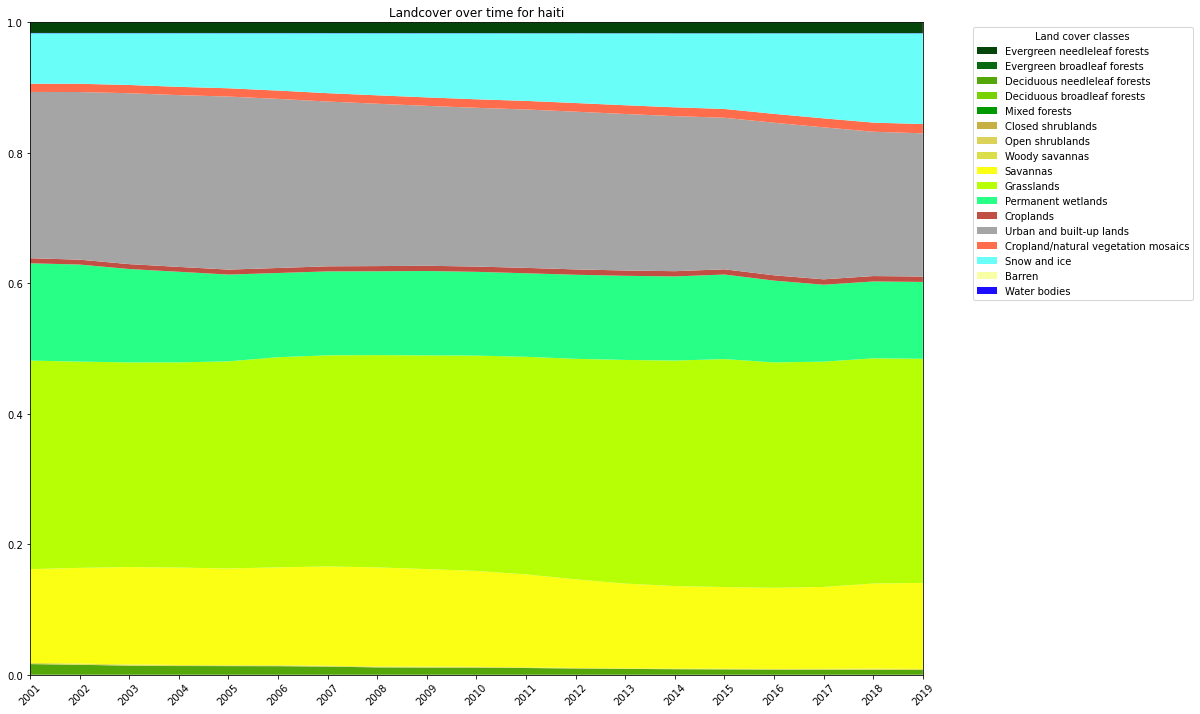

In [325]:
country = 'haiti'

#make a stack plot to show lc over time

fig, ax = plt.subplots(figsize=(16,12))

ax.set_title(f'Landcover over time for {country}')
labels = np.array(["Evergreen needleleaf forests", "Evergreen broadleaf forests", "Deciduous needleleaf forests", \
          "Deciduous broadleaf forests", "Mixed forests", "Closed shrublands", "Open shrublands", "Woody savannas", \
          "Savannas", "Grasslands", "Permanent wetlands", "Croplands", "Urban and built-up lands", \
          "Cropland/natural vegetation mosaics", "Snow and ice", "Barren", "Water bodies"])
lc_data = np.vstack(np.array(data[country]).T)

sort_mask = np.argsort(lc_data[:,0])
ax.stackplot(np.arange(2001,2001+N), lc_data, labels=labels, colors=np.array(igbpPalette))
ax.legend(title='Land cover classes', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xticks(list(range(2001,2001+N)))
plt.xticks(rotation=45)
plt.xlim(2001,2019); plt.ylim(0,1)
plt.savefig(f'{country}_full.png')
plt.show()

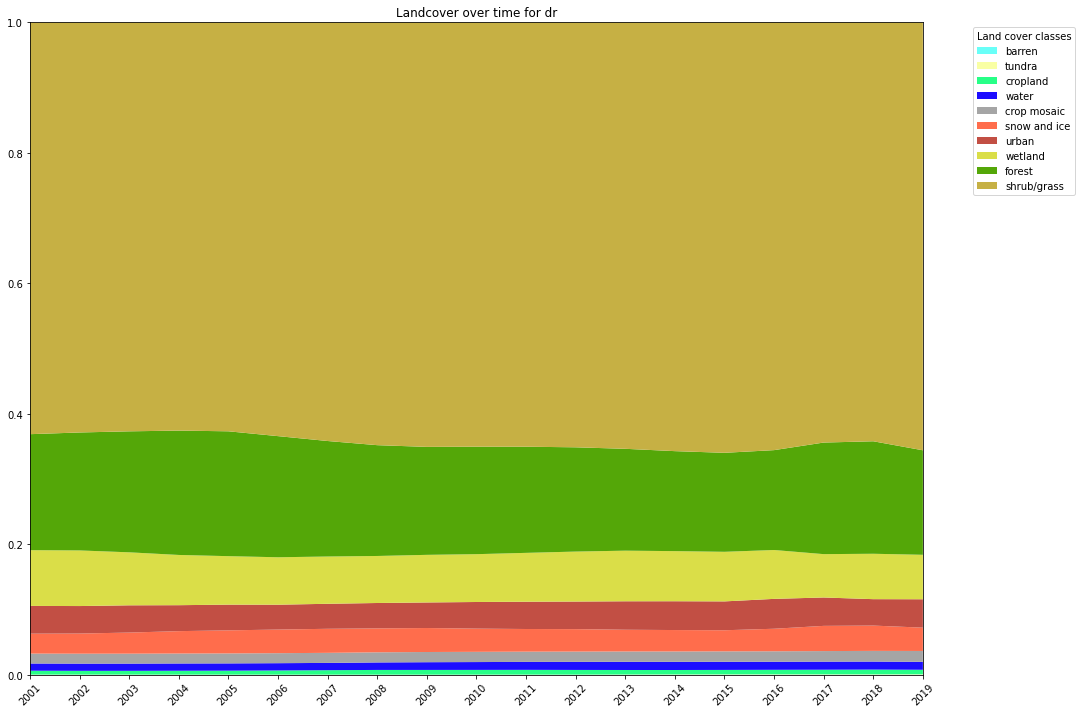

In [332]:
country = 'dr'

lc_data = np.vstack(np.array(data[country]).T)
lc_data_simplified = np.vstack([lc_data[0:6,:].sum(axis=0), lc_data[6:10,:].sum(axis=0), lc_data[10:]])
    
igbpPalette_simplified = np.array([
  '54a708', # forest
  'c6b044', # shrub, grass
  'dade48', # wetlands
  '27ff87', # croplands
  'c24f44', # urban
  'a5a5a5', # crop mosaic
  'ff6d4c', # snow and ice
  '69fff8', # barren
  'f9ffa4', # water
  '1c0dff', # tundra
])

#make a stack plot to show lc over time

fig, ax = plt.subplots(figsize=(16,12))

ax.set_title(f'Landcover over time for {country}')
labels = np.array(["forest", "shrub/grass", "wetland", "cropland", "urban", \
          "crop mosaic", "snow and ice", "barren", "tundra", "water"])

sort_mask = np.argsort(lc_data_simplified[:,0])
ax.stackplot(np.arange(2001,2001+N), lc_data_simplified[sort_mask], labels=labels[sort_mask], colors=igbpPalette_simplified[sort_mask])
ax.legend(title='Land cover classes', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xticks(list(range(2001,2001+N)))
plt.xticks(rotation=45)
plt.xlim(2001,2019); plt.ylim(0,1)

#plt.ylim(0,0.5)
plt.savefig(f'{country}_simp.png')
plt.show()